In [1]:
# !export CUDA_VISIBLE_DEVICES=2
import torch
from PIL import Image
import glob
import csv
import random
import numpy as np
from histolab.tiler import GridTiler
from histolab.slide import Slide
from histolab.masks import TissueMask
import os
import pandas as pd
from tqdm import tqdm

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(2022)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# data_dir = "/restricteddata/skincancer_kuk/Scanned_WSI/WSI/Derma_anonymized/bas_1/ICNNBCC00001"
# label_file = '/system/user/publicwork/yitaocai/CellLine_Microscopy/cell_line/y_train.csv'

# files = glob.glob(os.path.join(data_dir, '*.png'), recursive=True)
# # print(files)
# tile_pos = [(x.split(data_dir, 1)[-1].rstrip('.png')).split("_")[1] for x in files]
# # print(tile_pos)
# bag_name = data_dir.split("/")[-1]
# label = pd.read_csv(label_file,index_col=0)

# label['diagnosis_new']=label.apply(lambda row: 0 if (row['diagnosis_reviewed']=='no_bas') else 1, axis=1)
# l = label.loc[label["image_nr"] ==bag_name, 'diagnosis_new'].values[0]



def get_pos(dir):
    import re
    if os.path.exists(dir):
        files = sorted(glob.glob(os.path.join(dir, '*.png'), recursive=True), key=lambda f: int(re.split("[_ -]",os.path.basename(f))[1]))
    else:
        raise ValueError("{} does not exist".format(dir))

    image_pos_list = []
    for file in files:
        basename = os.path.basename(file).rstrip(".png")
        image_pos = [re.split("[_ -]", basename)[1]] + re.split("[_ -]", basename)[3:7]

        image_pos = [int(x) for x in image_pos]
        image_pos_list.append(image_pos)
    return image_pos_list



In [3]:
# data = pd.read_csv('/restricteddata/skincancer_kuk/Scanned_WSI/metadata.csv')
data= pd.read_csv('/restricteddata/skincancer_kuk/Scanned_WSI/metadata_workingfile_label.csv')

# data['label'] = data['diagnosis'].apply(lambda x: 0 if x =='normal' else (2 if x == 'scc' or x=='plep' or x== 'mb bowen_bowen_plep' else 1))
# data['label'] = data['diagnosis'].apply(lambda x: 0 if x =='normal' else (1 if x == 'bas' or 'bas_plep' else 2))
# data.to_csv('/restricteddata/skincancer_kuk/Scanned_WSI/metadata_workingfile_label.csv', index=False)

In [5]:
data

,image_nr,filename,diagnosis,set,label
0,5878813567,5878813567.svs,bas,train,1
1,6509209507,6509209507.svs,normal,train,0
2,8735530300,8735530300.svs,bas,train,1
3,006f78f1f7,006f78f1f7.svs,bas,train,1
4,0074ba770b,0074ba770b.svs,bas,train,1
...,...,...,...,...,...
1121,ICNNBCC00753,ICNNBCC00753.mrxs,bas,val,1
1122,ICNNBCC00754,ICNNBCC00754.mrxs,bas,train,1
1123,ICNNBCC00755,ICNNBCC00755.mrxs,bas,train,1
1124,ICNNBCC00756,ICNNBCC00756.mrxs,scc,train,2


In [4]:
# filenames = list(data['filename'].values)


diagnosis = data['diagnosis'].values
labels = data['label'].values
serial_no = list(data['image_nr'].values)
# serial_no = list(data['slidename'].values)
filenames =[ fn.rstrip('.mrxs') for fn in data['filename'].values]
# filenames = [fn.rstrip('.svs') for fn in data['filepath'].values]

# filenames.index(svs_files[260])
print(diagnosis[0])
# print(svs_files[260])
# filenames[0]+'/'
# filenames

# data.loc[os.path.basename(data_dir) == data['image_nr'], 'label'].values[0]



bas


In [7]:
np.unique(diagnosis, return_counts=True)
from collections import Counter
Counter(diagnosis)
Counter(labels)

Counter({1: 759, 0: 297, 2: 70})

In [8]:
df = data
# df.loc[df["filename"] == "T19-18-00-R2-S3.mrxs"]["image_nr"].values[0]

def rename(path,format,df):
    import re
    mrxs_files = sorted(glob.glob(os.path.join(path, '*'+ format), recursive=True))
    data_files = sorted(glob.glob(os.path.join(path,'*/'), recursive=True))

    for mrxs, data in zip(mrxs_files, data_files):

        basename_mrxs = os.path.basename(mrxs)
        basename_data = os.path.basename(os.path.dirname(data))
    

        
        filename_mrxs = "T" + re.split("T", basename_data)[1] + format
        
        
        try:
            image_name = df.loc[df["filename"] == filename_mrxs]["image_nr"].values[0]
            os.rename(mrxs, os.path.join(path, str(image_name) + format))
            os.rename(data, os.path.join(path, str(image_name)))
        except:
            continue

In [9]:


def get_tiles(slidepath, basepath, labels, serial_no, format = ".mrxs",tile_size = 512 ):


    slides_files = sorted(glob.glob(os.path.join(slidepath, '*'+ format), recursive=True))
    # print(slides_files[0:5])

    slides = [os.path.basename(f).rstrip(format) for f in slides_files]

    PROCESS_NORMAL_PATH = os.path.join(basepath,'0_normal')
    PROCESS_BAS_PATH = os.path.join(basepath,'1_bas')
    PROCESS_SCC_PATH = os.path.join(basepath,'2_scc')
 
    if not os.path.exists(PROCESS_NORMAL_PATH) or not os.path.exists(PROCESS_BAS_PATH) or not os.path.exists(PROCESS_SCC_PATH):
        os.makedirs(PROCESS_NORMAL_PATH)
        os.makedirs(PROCESS_BAS_PATH)
        os.makedirs(PROCESS_SCC_PATH)

    print(f"start processing {len(slides)} slides")
    i=0
    pbar = tqdm(enumerate(slides), total=len(slides))
    for _ , filename in pbar:


        print(f"filename is {filename}")
        print(f"filesname is in serial_no {filename in serial_no}")
        if filename in serial_no:
            i+=1
            # pbar.set_description(f"Start processing slide {i} {filename} ")
            temp_slidepath = os.path.join(slidepath, filename + format)  

            
            idx = serial_no.index(filename)
            if labels[idx] == 0:

                slide = Slide(temp_slidepath, processed_path = PROCESS_NORMAL_PATH)
            elif labels[idx] == 1:
  
                slide = Slide(temp_slidepath, processed_path = PROCESS_BAS_PATH)
            elif labels[idx] == 2:

                slide = Slide(temp_slidepath, processed_path = PROCESS_SCC_PATH)
            

            grid_tiles_extractor = GridTiler(
                tile_size=(tile_size, tile_size),
                level=1,
                check_tissue=True, # default
                tissue_percent=0.95,
                pixel_overlap=0, # default
                prefix = filename +'/', # save tiles in the "grid" subdirectory of slide's processed_path
                suffix=".png" 
                )
            
            grid_tiles_extractor.locate_tiles(
                slide=slide,
                extraction_mask = TissueMask(),
                scale_factor=64,
                alpha=64,
                outline="#046C4C",
            )
            grid_tiles_extractor.extract(slide)
            
           
            pbar.set_description(f"The tiling of the slide {i}  {filename}  is done")
        else:
            continue
    print(f"{i} slides are processed")




In [10]:

def tile_a_slide(slidepath, basepath, labels, serial_no, format = ".mrxs",tile_size = 512 ):


    # slides_files = sorted(glob.glob(os.path.join(slidepath, '*'+ format), recursive=True))
    # print(slides_files[0:5])

    filename = os.path.basename(slidepath).rstrip(format) 

    PROCESS_NORMAL_PATH = os.path.join(basepath,'0_normal')
    PROCESS_BAS_PATH = os.path.join(basepath,'1_bas')
    PROCESS_SCC_PATH = os.path.join(basepath,'2_scc')
 
    if not os.path.exists(PROCESS_NORMAL_PATH) or not os.path.exists(PROCESS_BAS_PATH) or not os.path.exists(PROCESS_SCC_PATH):
        os.makedirs(PROCESS_NORMAL_PATH)
        os.makedirs(PROCESS_BAS_PATH)
        os.makedirs(PROCESS_SCC_PATH)



    print(f"filename is {filename}")
    print(f"filesname is in serial_no {filename in serial_no}")
    if filename in serial_no:
       
        temp_slidepath = slidepath                                         
        
        idx = serial_no.index(filename)
        if labels[idx] == 0:

            slide = Slide(temp_slidepath, processed_path = PROCESS_NORMAL_PATH)
        elif labels[idx] == 1:

            slide = Slide(temp_slidepath, processed_path = PROCESS_BAS_PATH)
        elif labels[idx] == 2:

            slide = Slide(temp_slidepath, processed_path = PROCESS_SCC_PATH)
        

        grid_tiles_extractor = GridTiler(
            tile_size=(tile_size, tile_size),
            level=1,
            check_tissue=True, # default
            tissue_percent=0.95,
            pixel_overlap=0, # default
            prefix = filename +'/', # save tiles in the "grid" subdirectory of slide's processed_path
            suffix=".png" 
            )
        
        grid_tiles_extractor.locate_tiles(
            slide=slide,
            extraction_mask = TissueMask(),
            scale_factor=64,
            alpha=64,
            outline="#046C4C",
        )
        grid_tiles_extractor.extract(slide)
        
    print(f"the slide {filename} is processed")
        
        

 

In [11]:

basepath = '/restricteddata/skincancer_kuk/tiles_20x/Tiles'

WSI_PATH = '/restricteddata/skincancer_kuk/WSI'
TILES_PATH = '/restricteddata/skincancer_kuk/tiles_20x/Tiles'
all_mrxs_slides = sorted(glob.glob(os.path.join(WSI_PATH, '*'+ '.mrxs'), recursive=True))
all_svs_slides = sorted(glob.glob(os.path.join(WSI_PATH, '*'+ '.svs'), recursive=True))
processed_slides = sorted(glob.glob(os.path.join(TILES_PATH, "*",'*/'), recursive=True))

processed_slides_list = [os.path.basename(os.path.dirname(slide))for slide in processed_slides]
# print(processed_slides_list)
mrxs_slide_list = all_mrxs_slides.copy()
svs_slide_list = all_svs_slides.copy()
for slide in all_mrxs_slides:
    basename = os.path.basename(slide).rstrip('.mrxs')

    if basename in processed_slides_list:
        mrxs_slide_list.remove(slide)
for slide in all_svs_slides:
    basename = os.path.basename(slide).rstrip('.svs')

    if basename in processed_slides_list:
        svs_slide_list.remove(slide)
        
print(mrxs_slide_list)
print(svs_slide_list)
print(len(mrxs_slide_list))
print(len(svs_slide_list))


[]
['/restricteddata/skincancer_kuk/WSI/df05d0a3ac.svs']
0
1


In [17]:
tile_a_slide("/restricteddata/skincancer_kuk/WSI/ICNNBCC00740.mrxs", basepath, labels, serial_no, format = ".mrxs",tile_size = 512 )

filename is ICNNBCC00740
filesname is in serial_no True
the slide ICNNBCC00740 is processed


In [16]:
start = 0
stop = 1
pbar = tqdm(range(start,stop),total=stop-start,desc="Processing slides")
for i in pbar:
# for i in range(5):
    tile_a_slide(mrxs_slide_list[i], basepath, labels, serial_no, format = ".mrxs",tile_size = 512 )
    

Processing slides:   0%|          | 0/1 [00:00<?, ?it/s]

filename is ICNNBCC00740
filesname is in serial_no True


Processing slides: 100%|██████████| 1/1 [02:26<00:00, 146.57s/it]

the slide ICNNBCC00740 is processed


In [20]:

slidepath = '/restricteddata/skincancer_kuk/Scanned_WSI/WSI/Derma_anonymized/batch_0/batch_0'
basepath = '/restricteddata/skincancer_kuk/tiles_20x/Tiles'
get_tiles(slidepath, basepath, labels, serial_no, format = ".mrxs",tile_size = 512 )

['/restricteddata/skincancer_kuk/Scanned_WSI/WSI/Derma_anonymized/batch_0/batch_0/ICNNBCC00692.mrxs', '/restricteddata/skincancer_kuk/Scanned_WSI/WSI/Derma_anonymized/batch_0/batch_0/ICNNBCC00693.mrxs']
start processing 2 slides


  0%|          | 0/2 [00:00<?, ?it/s]

filename is ICNNBCC00692
filesname is in serial_no True


The tiling of the slide 1  ICNNBCC00692  is done:  50%|█████     | 1/2 [1:12:25<1:12:25, 4345.41s/it]

filename is ICNNBCC00693
filesname is in serial_no True


The tiling of the slide 2  ICNNBCC00693  is done: 100%|██████████| 2/2 [2:03:45<00:00, 3712.98s/it]  

2 slides are processed


In [10]:
s_path = "/restricteddata/skincancer_kuk/Scanned_WSI/WSI/Derma_anonymized/SVS/ICNNBCC00002.svs"
slide = Slide(s_path, processed_path = '/restricteddata/skincancer_kuk/Scanned_WSI/WSI/Derma_anonymized/SVS/ICNNBCC00002')
grid_tiles_extractor = GridTiler(
                tile_size=(512, 512),
                level=0,
                check_tissue=True, # default
                tissue_percent=0.95,
                pixel_overlap=0, # default
                prefix = "", # save tiles in the "grid" subdirectory of slide's processed_path
                suffix=".png" 
                )
            

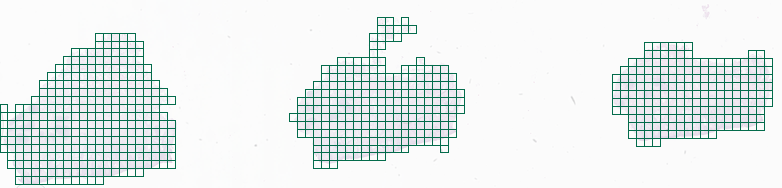

In [14]:
grid_tiles_extractor.locate_tiles(
    slide=slide,
    extraction_mask = TissueMask(),
    scale_factor=64,
    alpha=64,
    outline="#046C4C",
)

In [1]:
get_tiles(slidepath,basepath, labels,filenames,format='.svs')


KeyboardInterrupt



In [8]:
def combine_feats_df(path1,path2,path3,out_path):
    """
    Collects the features files from the files in the given path.
    """
    feats1_files = sorted(glob.glob(os.path.join(path1, "*", "*.csv"), recursive=True))
    feats2_files = sorted(glob.glob(os.path.join(path2, "*", "*.csv"), recursive=True))
    feats3_files = sorted(glob.glob(os.path.join(path3, "*", "*.csv"), recursive=True))
    processed_slides_files = sorted(glob.glob(os.path.join(out_path, "*.csv"), recursive=True))
    processed_slides_list = [os.path.basename(slide).split(".")[0] for slide in processed_slides_files]
    
    for bag1,bag2,bag3 in zip(feats1_files,feats2_files,feats3_files):

        basename = os.path.basename(bag1)
    
        if basename in processed_slides_list:
            # print(basename)
            feats1_files.remove(bag1)
            feats2_files.remove(bag2)
            feats3_files.remove(bag3)

    for file1,file2,file3 in zip(feats1_files,feats2_files,feats3_files):
        if os.path.basename(file1) == os.path.basename(file2) == os.path.basename(file3):
            df1 = pd.read_csv(file1,header=None)
            df2 = pd.read_csv(file2,header=None)
            df3 = pd.read_csv(file3,header=None)
            
            df = pd.concat([df1,df2,df3],axis=1,ignore_index=True)
            df = df.drop([0])
            out_path_i = os.path.join(out_path,os.path.basename(os.path.dirname(file1)))
            if not os.path.exists(out_path_i):
                os.makedirs(out_path_i)
            df.to_csv(os.path.join(out_path_i,os.path.basename(file1) ),index=False)

    return None

In [9]:

path_cnt = "/restricteddata/skincancer_kuk/tiles_20x/Features/ConvNext_20X"

path_vig = "/restricteddata/skincancer_kuk/tiles_20x/Features/VIG_20X"
path_van = "/restricteddata/skincancer_kuk/tiles_20x/Features/Van_20X"
out_path = "/system/user/publicwork/yitaocai/Master_Thesis/Integrated_CVV20X_Dataset"
combine_feats_df(path_cnt,path_vig,path_van,out_path)
      




## Get Features Dataset

In [ ]:
from BagDataset import *
feats_path =  '/restricteddata/skincancer_kuk/Scanned_WSI/Datasets/'
bags_path = '/restricteddata/skincancer_kuk/Scanned_WSI/Histo_Images/'
    
os.makedirs(feats_path, exist_ok=True)
bags_list = glob.glob(bags_path,'*','*',recursive=True)
batch_size = 256
i_classfier = model

In [ ]:
compute_feats(label_file, bags_list, i_classifier, batch_size, transforms, save_path=None)